# Imports

In [2]:
!pip install tensorflow_hub
!pip install keras tf-models-official pydot graphviz

     |████████████████████████████████| 849kB 4.5MB/s 
     |████████████████████████████████| 102kB 8.3MB/s 
     |████████████████████████████████| 36.7MB 80kB/s 
     |████████████████████████████████| 174kB 52.6MB/s 
     |████████████████████████████████| 358kB 55.4MB/s 
     |████████████████████████████████| 1.1MB 53.8MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-7.0.0-cp36-none-any.whl size=20071 sha256=fb29c88671f4424097da31312b80cdd8c6bbb16e37873c7eca0cde1a0fda681b
  Stored in directory: /root/.cache/pip/wheels/f1/93/7b/127daf0c3a5a49feb2fecd468d508067c733fba5192f726ad1
Successfully built py-cpuinfo


In [3]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.3.0
Eager mode:  True
Hub version:  0.9.0
GPU is available


# Data

For this example you need to download twitter data from Kaggle: https://www.kaggle.com/kazanova/sentiment140

Context \\
\
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment. \\
\
Content \\
\
It contains the following 6 fields:
* target: the polarity of the tweet (0 = negative, 4 = positive)

* ids: The id of the tweet ( 2087)

* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

* flag: The query (lyx). If there is no query, then this value is NO_QUERY.

* user: the user that tweeted (robotickilldozr)

* text: the text of the tweet (Lyx is cool)

Acknowledgements \\
The official link regarding the dataset with resources about how it was generated is [here](http://%20http//help.sentiment140.com/for-students/) \\
The official paper detailing the approach is [here](http://bhttp//cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [ ]:
df = pd.read_csv('/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/twitter_data/training.1600000.processed.noemoticon.csv',
                 encoding='ISO-8859-1', 
                 names=[
                        'target',
                        'id',
                        'date',
                        'flag',
                        'user',
                        'text'
                        ])

In [ ]:
df.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


We have two classes in the dataset

In [ ]:
df.target.unique()

array([0, 4])

Let's check how equally distributed those classes are.

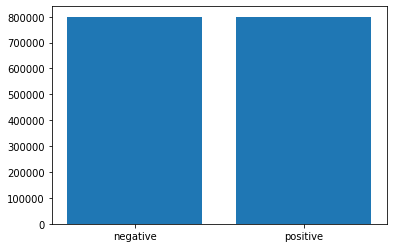

In [ ]:
classes = df.target.unique()
counts = []

for i in classes:
  count = len(df[df.target==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

Even class distribution helps us a lot in text classifiction. Imagine a situation where 95% of data is in one class and the rest 5% is split among other 5 classes. If we wouldn't do anything about it model would just learn to guess the 95% class all the time and would be correct 95% of the time on the data we would use.

## Correlation check for our new feature/input

So in this notebook we want to add something additional to BERT to check. Easiest way to check for some variables here is making some features either from `text` or `date`. Maybe `user` would be an option as well. If you want to practice that could be a good goto.

### Upper vs. lower case ussage in tweets

Assumption - people shout (uppercase) in their tweets when they are mad, thus negative sentiment.

Let's calculate somewhat a score of how SHOUTING a tweet is.

In [ ]:
df['upper'] = [np.sum([i.isupper() for i in l])/len(l) for l in df.text]

Check average scores for both.

In [ ]:
for i in df.target.unique():
  print('Target: ', i, 'Score: ', df[df.target == i]['upper'].mean())

Target:  0 Score:  0.04320155098988484
Target:  4 Score:  0.04989933275850178


Doesn't seem to have any weight to it. Let's check correlation just to be sure.

In [ ]:
df[['target', 'upper']].corr()

,target,upper
target,1.000000,0.046258
upper,0.046258,1.000000


Yeah.. we can skip this one.

### Weekday influence on your tweet sentiment

Assumption - on some days you are more likely to be mad/happy, thus sentiment.

Let's compare the counts first.

In [ ]:
df['wkd'] = [i[0:3] for i in df['date']]

In [ ]:
negativeCount = df[df.target == 0]['wkd'].value_counts()
positiveCount = df[df.target == 4]['wkd'].value_counts()  

In [ ]:
countDf = pd.DataFrame()
countDf['wkd'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
countDf['negative'] = [negativeCount[i] for i in countDf['wkd']]
countDf['positive'] = [positiveCount[i] for i in countDf['wkd']]

countDf

,wkd,negative,positive
0,Mon,132539,177666
1,Tue,101051,84799
2,Wed,68473,28333
3,Thu,80132,25903
4,Fri,114600,110994
5,Sat,157734,173221
6,Sun,145471,199084


We may be able to work with this. From class distribution we know that there's about the same number of positive and negative tweets. Knowing that we can see that there are some differences in tweet sentiment distribution in different weekdays like `Thu` having around `3:1` `negative` vs. `positive` tweets.

In [ ]:
for i in df.wkd.unique():
  df[i] = [int(i==l) for l in df.wkd]

In [ ]:
df[['target','Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']].corr()['target']

target    1.000000
Mon       0.071343
Tue      -0.031701
Wed      -0.105225
Thu      -0.136250
Fri      -0.006476
Sat       0.023897
Sun       0.081516
Name: target, dtype: float64

From correlations we see that `Thu` thing could maybe work.

### Hour impact on tweet sentiment

Well before jumping in let's test hour influence on tweets as well. Problem with that being is that most probably tweet date is set "globaly" and not reflective of the timezone the person is. Anyway, let's check that as well.

In [ ]:
df['hour'] = [i[11:13] for i in df['date']] 

In [ ]:
hourCount = pd.DataFrame()

hourCount['hour'] = df['hour'].unique()
countDict = {}

for i in df.target.unique():
  countDict[i] = df[df.target == i]['hour'].value_counts()

In [ ]:
for i in countDict:
  if i == 0:
    sentiment = 'negative'
  else:
    sentiment = 'positive'
  hourCount[sentiment] = [countDict[i][h] for h in hourCount['hour']]

hourCount.sort_values(by=['hour'], inplace=True)
hourCount.reset_index(drop=True, inplace=True)
hourCount

,hour,negative,positive
0,00,35582,45283
1,01,30581,44687
2,02,30171,43820
3,03,31717,42536
4,04,34946,42049
5,05,37774,40849
6,06,40076,40776
7,07,42208,41446
8,08,40166,36121
9,09,36511,30767


Too much lines, it's hard to read. Let's make a plot

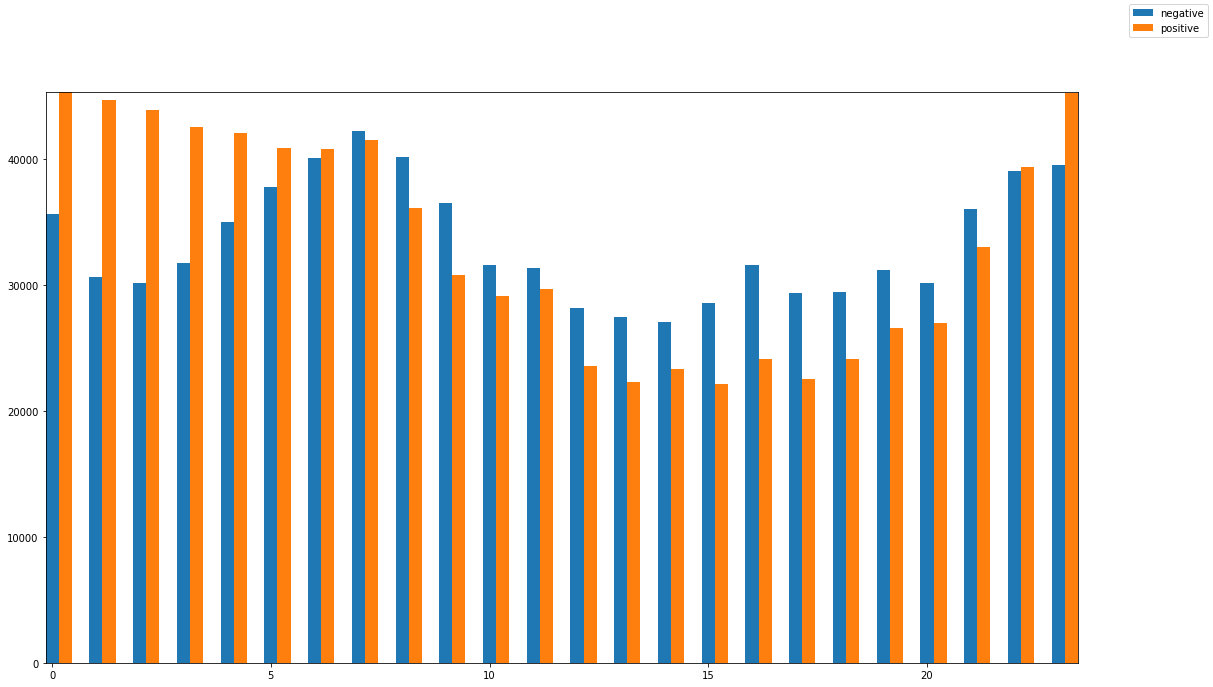

In [ ]:
w = 0.3
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for count, i in enumerate(hourCount.columns[1:]):
  ax.bar(x=hourCount.index+count*w, width=w, height=hourCount[i])

ax.autoscale(tight=True)
fig.set_size_inches(18.5, 10.5)
fig.legend(hourCount.columns[1:])
fig.show()

Cool, so we see there's some difference between positive and negative tweet hours. Let's check the correlation for that as well. After this we will get back to modelling, I swear.

In [ ]:
for i in df.hour.unique():
  df[i] = [int(i==l) for l in df.hour]

In [ ]:
cols = [i for i in hourCount.hour]
cols.append('target')

df[cols].corr()['target']

00        0.027678
01        0.041639
02        0.040619
03        0.032143
04        0.020742
05        0.008891
06        0.001997
07       -0.002140
08       -0.011864
09       -0.017887
10       -0.008196
11       -0.005427
12       -0.016220
13       -0.018768
14       -0.013507
15       -0.022916
16       -0.025459
17       -0.023964
18       -0.018633
19       -0.015632
20       -0.010599
21       -0.009386
22        0.000846
23        0.016012
target    1.000000
Name: target, dtype: float64

There's nothing significant, but then again we are using neural network and not a regression to do this. There's some dynamic from the plot we checked, we could use both `hour` and `wkd` if we wanted. I'll leave this one for you and do the rest of tutorial with the `wkd` variable just because of the global time issue I've mentioned before.

To start modelling we still need to do a couple of things:

1.   Split data into train and test datasets
2.   Encode labels
3.   Encode our new feature `wkd`
4.   Tokenize text



## Train/test split

We don't really need all 1.6 Million tweets for training so we can take a sample of 5% (to save up time on training) and then split that into 80% for training and 20% for testing.

In [ ]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=23)
wkd = sampleDf.wkd.values
x = sampleDf.text.values
y = sampleDf.target.values
wkd_train, wkd_test, x_train, x_test, y_train, y_test = train_test_split(wkd, x, y, test_size=0.20, random_state=32)

## Label Encoding

We could get away with other approach but you might want to use this for more than binary classification.

In [ ]:
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

We might want to use encoding for later. For that we can save enconding map.

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

To load it when you'll use this in production just use the below cell (uncommented ofcourse)

In [ ]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## Tokenization

To tokenize our text we will use some functions from official.nlp.bert package and the pretrained BERT model itself. \\
First we get the BERT model. I'll use the multilingual one as it will be best for most of your cases. To check all NLP models provided by TF HUB go [here](https://tfhub.dev/s?module-type=text-embedding,text-classification,text-generation,text-language-model,text-question-answering,text-retrieval-question-answering).

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2",
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

You can see that in above cell we have loaded some variables using the bert_layer we have downloaded. 

1.   ```vocab_file``` reads the vocab file associated to the downloaded model.
2.   ```do_lower_case``` reads binary variable which if ```True``` means tokenizer will reformat all text to lower case rendering model to be **NOT** case sensitive. Should be ```False``` by default. You can check in a cell below.
3.   ```tokenizer``` builds tokenizer using variables 1 and 2.



In [ ]:
do_lower_case

False

Lastly we need to add two additional tokens: Classification and Seperation. We will add these through functions we will use to tokenize our text.

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

Kewl, by this point we have everything for tokenization. This will take a bit as we have quite a bit of data.

## Prep inputs

So since we went extensively through input prep in last video where we finetune non modified BERT model, this time we'll jump straight to input prep through functions. Everything that will be different from the old notebook will have **[NEW]** next to it. Our inputs are:

1.   Tokens
2.   Input mask
3.   Input type
4.   **[NEW]** Weekday

Remember when I said it will make our work easier both now and in the future if we remake everything into funcitons? Now is that future.



First let's set the max sequence lenght as we did in simple NN example.

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

tweets = tf.ragged.constant([encode_names(n, tokenizer) for n in x_train])
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*tweets.shape[0]
input_word_ids = tf.concat([cls, tweets], axis=-1)

lens = [len(i) for i in input_word_ids]

In [ ]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 160


Most of the time I suggest adding a bit more to the `max_seq_length` esspecially when ussing just a fraction of data. Let's make it `1.5*max_seq_length`.

In [ ]:
max_seq_length = int(1.5*max_seq_length)
print('Max length is:', max_seq_length)

Max length is: 240


**[NEW]** We need to encode our `wkd` classes and update our input functions to include that.

In [ ]:
featureEncoder = LabelEncoder()
featureEncoder.fit(wkd)

# encode
encoded_wkd_train = featureEncoder.transform(wkd_train)
encoded_wkd_test = featureEncoder.transform(wkd_test)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_wkd_train = np_utils.to_categorical(encoded_wkd_train)
dummy_wkd_test = np_utils.to_categorical(encoded_wkd_test)

**[NEW]** And once again save this encoder for later as we did with labels.

In [ ]:
featureEncoder_fname = 'twitter_wkd.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'
np.save(os.path.join(my_wd, featureEncoder_fname) , featureEncoder.classes_)

Now we can make our inputs for train and test subsamples. There will be **[NEW]** as a comment to new lines which differ from our last notebook.

In [4]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list,
                tokenizer, 
                new_feature,  # [NEW]
                new_feature_class_count,  # [NEW] 
                max_seq_length):  
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))
  feature = tf.ragged.constant(new_feature).to_tensor(shape=(None, new_feature_class_count))  # [NEW]

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids,
      'additional_feature': feature}  # [NEW]

  return inputs

**[NEW]** And now we preprocess inputs.

In [ ]:
feature_class_count = len(df.wkd.unique())
X_train = bert_encode(x_train, tokenizer, dummy_wkd_train, feature_class_count, max_seq_length)
X_test = bert_encode(x_test, tokenizer, dummy_wkd_test, feature_class_count, max_seq_length)

# Bam MODEL part already

## Initial training

We need to set up our model using the inputs we made, BERT model that we downloaded and an output layer based on num of classes we are using. Check for **[NEW]** lines to understand the addition to our inputs.

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")
feature_input = tf.keras.layers.Input(shape=(feature_class_count,),  # [NEW]
                                      dtype=tf.float32, 
                                      name="additional_feature")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])    

output = tf.keras.layers.concatenate([pooled_output, feature_input], name='pooled_with_additional')  # [NEW]

output = tf.keras.layers.Dropout(rate=0.1)(output)  # [NEW]

  # additional dense layer here

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids,
        'additional_feature': feature_input  # [NEW]
        },
        outputs=output)

Our model.

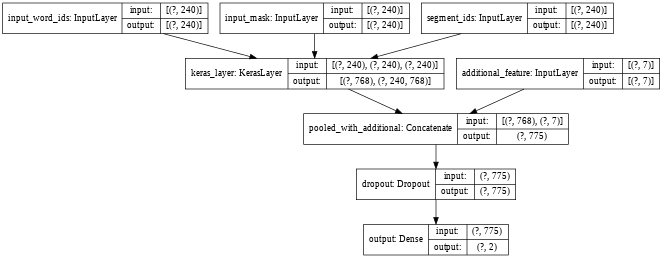

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

**[NEW]** As you can see from the plot above we have two additional layers:


1.   `additional_feature` - our new input layer
2.   `pooled_with_additional` - concatenated layer from `pooled_output` of BERT and our new `additional_feature`



Set up the training parameters.

In [ ]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile the model.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

Set up a history to check our model performance afterwards.

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
4000/4000 [==============================] - ETA: 0s - loss: 0.4747 - accuracy: 0.7708WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0120s vs `on_test_batch_end` time: 0.1475s). Check your callbacks.


4000/4000 [==============================] - 2196s 549ms/step - loss: 0.4747 - accuracy: 0.7708 - val_loss: 0.4025 - val_accuracy: 0.8181
Epoch 2/3
4000/4000 [==============================] - 2196s 549ms/step - loss: 0.3535 - accuracy: 0.8444 - val_loss: 0.3888 - val_accuracy: 0.8259
Epoch 3/3
4000/4000 [==============================] - 2195s 549ms/step - loss: 0.2533 - accuracy: 0.8956 - val_loss: 0.4366 - val_accuracy: 0.8298


Evaluation

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.9414
Testing Accuracy:  0.8298


Noice plots are noice

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

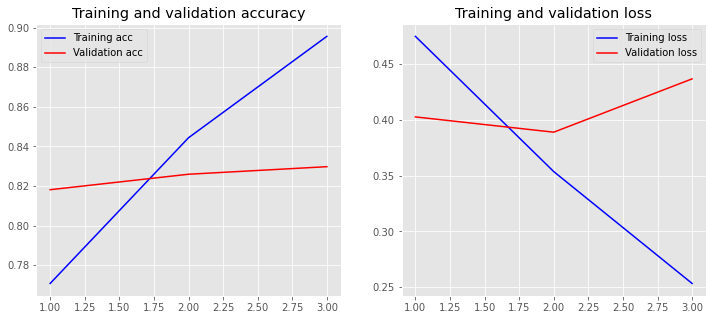

In [ ]:
plot_history(history)

So, looking at the plot above we can see that at the 3rd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. If we would train it more on the same data it would significantly overtrain. \\
What we can do instead is make another training dataset, lower our learning rate commonly denoted as `lr`, recompile our model using new `lr` and then train it a bit more. \\
But before doing that we should save our model just in case if we would want to do the additional training in later sessions.

## Model saving for later use

Let's save our model for later use. Unfortunatelly we can't use the optimizer we used for model training to save. I get an error and I can't resolve it. So we will recompile our model before saving.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'twitter_BERT_wWKD'  # [NEW]
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

model.save(os.path.join(my_wd, model_fname))

### Validate saved model

Sometimes TF likes to corrupt your model when saving. It's always a good idea to check if everything loads correctly after save.

In [6]:
new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8298


In [ ]:
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

For safety reasons I would check the tokenizer variables as well.

In [12]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

If this loads, you should be fine.

In [ ]:
tokenizedTweet = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedTweet:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

I [146]
F [143]
##O [11403]
##UN [69849]
##D [11490]
O [152]
##UT [65729]
T [157]
##HA [58132]
##T [11090]
THE [17443]
##Y [14703]
PA [32349]
##Y [14703]
THE [17443]
W [160]
##HI [108880]
##TE [29833]
CH [39774]
##IC [30889]
##K [11733]
MO [102059]
##RE [66014]
T [157]
##HA [58132]
##N [11537]
ME [47430]
W [160]
##H [12396]
##Y [14703]
? [136]
? [136]
I [146]
DO [99843]
##NT [77261]
K [148]
##NO [67292]
##W [13034]
! [106]
! [106]
! [106]
W [160]
##HA [58132]
##T [11090]
SH [38702]
##O [11403]
##UL [100673]
##D [11490]
I [146]
DO [99843]
? [136]
? [136]
? [136]


As everything seems fine, we can move on to second training itteration and try to make our model a bit better.

## Second training itteration

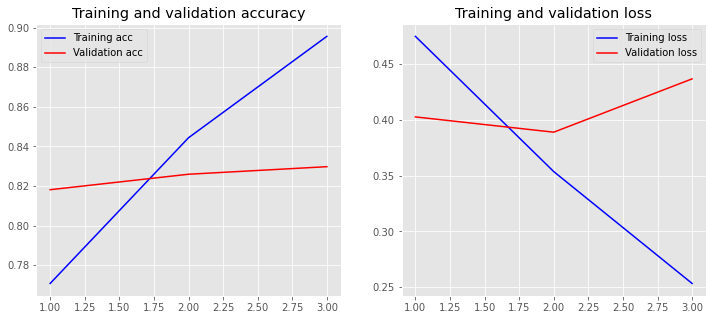

In [ ]:
plot_history(history)

As mentioned before, looking at the plot above we can see that at the 3rd epoch our `Validation Loss` jumped significantly even though `Validation Accuracy` stayed pretty much the same. If we would train it more on the same data it would significantly overtrain. \\

What we can do instead is make another training dataset, lower our learning rate commonly denoted as `lr`, recompile our model using new `lr` and then train it a bit more.

Are there any other options to approach overtraining? Sure. One of the most obvious ways would be to increase dropout layer number or the dropout precentage. You could try playing around with pooling as well, but in essence dropout would be your go to. 

If you do not know what dropout is then in short it 'turns off' preceeding layer neurons before next layer calculation, thus increasing the need for the model to 'abstract' things it sees.

Anyway, in our case we are doing `lr` change and adding new data for the model. Let's see how that goes.

### Data

First we need to prep our data. It's good that we made our processing easier making some functions. Let's take another 5% sample from our data.

In [ ]:
sample_size = int(len(df)*0.05)
sampleDf = df.sample(sample_size, random_state=42)
wkd = sampleDf.wkd.values
x = sampleDf.text.values
y = sampleDf.target.values
wkd_train2, wkd_test2, x_train2, x_test2, y_train2, y_test2 = train_test_split(wkd, x, y, test_size=0.20, random_state=23) 

[0 4]


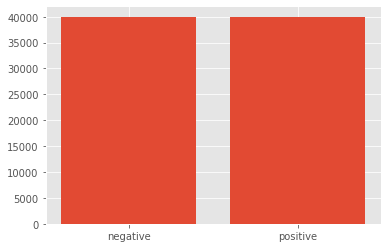

In [ ]:
classes = sampleDf.target.unique()
print(classes)
counts = []

for i in classes:
  count = len(sampleDf[sampleDf.target==i])
  counts.append(count)

plt.bar(['negative', 'positive'], counts)
plt.show()

It's not a bad idea to always check if your sample is representitive of the dataset itself. Most of the time it will, but when getting small samples it might be off in small datasets.

#### Label Encoding
Now we need to encode labels again. Good thing we have our label encoder saved.

In [ ]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

encoded_Y_test2 = encoder.transform(y_test2)
encoded_Y_train2 = encoder.transform(y_train2)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test2 = np_utils.to_categorical(encoded_Y_test2)
dummy_y_train2 = np_utils.to_categorical(encoded_Y_train2)

#### Input preprocessing
As we did before we need to tokenize our inputs (tweets) as `input_word_ids` and then add `input_mask` and `input_type`, as well as, `wkd` for weekday input. As we saved our model, we can use it to build our tokenizer as it was.

In [ ]:
model_fname = 'twitter_BERT'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

And use our feature label encoder that we saved earlier.

In [ ]:
encoder_fname = 'twitter_wkd.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

featureEncoderSaved = LabelEncoder()
featureEncoderSaved.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

# encode
encoded_wkd_train = featureEncoderSaved.transform(wkd_train2)
encoded_wkd_test = featureEncoderSaved.transform(wkd_test2)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_wkd_train2 = np_utils.to_categorical(encoded_wkd_train)
dummy_wkd_test2 = np_utils.to_categorical(encoded_wkd_test)

I repaste our encoding functions here so it would be easier to follow.

In [6]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list,
                tokenizer, 
                new_feature,  # [NEW]
                new_feature_class_count,  # [NEW] 
                max_seq_length):  
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))
  feature = tf.ragged.constant(new_feature).to_tensor(shape=(None, new_feature_class_count))  # [NEW]

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids,
      'additional_feature': feature}  # [NEW]

  return inputs

As you can see in the functions we use max_seq_length to convert our tweets into inputs. We can't really change it from the one used to build our model as it is in the model structure itself. See below.

In [ ]:
print('Max sequence length is:', max_seq_length)

Max sequence length is: 240


In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

You can see that all of the BERT `InputLayers` have a shape of (0, 240) which is (0, `max_seq_length`). For that reason we must use the same `max_seq_length` for our model to understand the inputs it gets. 

Also, the `additional_feature` input layer has a shape of (0, `feature_class_count`), where `feature_class_count` is 7 as in 7 days in the week.

Now we will use the above functions to make all 4 of our inputs. Do

In [ ]:
feature_class_count = 7  # days in week
X_train2 = bert_encode(x_train2, tokenizerSaved, dummy_wkd_train2, feature_class_count, max_seq_length)
X_test2 = bert_encode(x_test2, tokenizerSaved, dummy_wkd_test2, feature_class_count, max_seq_length)

So here we change only actual inputs of the model but not the contants set by our model architecture which are `feature_class_count` and `max_seq_length`. You could actually just input integers there instead of variables as we know them based on our model.

### Training

Firstly let's load our saved model.

In [ ]:
model_fname = 'twitter_BERT_wWKD'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

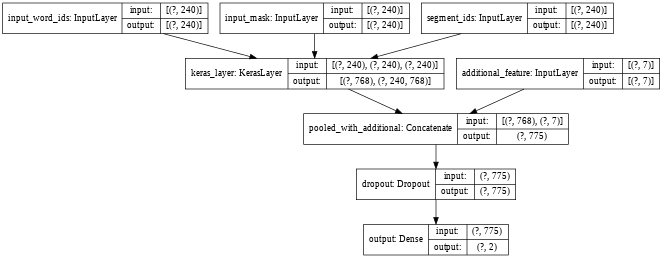

In [ ]:
tf.keras.utils.plot_model(new_model, show_shapes=True, dpi=48)

To check training progress we can use the new and the old testing datasets. Their accuracy should be close. Let's see how it compares.

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)  # OLD
print("Old testing Accuracy:  {:.4f}".format(accuracy))

loss, accuracy = new_model.evaluate(X_test2, dummy_y_test2, verbose=False)  # NEW
print("New testing Accuracy:  {:.4f}".format(accuracy))

Old testing Accuracy:  0.8298
New testing Accuracy:  0.8305


As you can see there's some difference. In any case, I suggest you use the same testing sample to proceed with you training no matter if the accuracy is the same. This of course applies only to when you do not train on the full dataset.

We need to setup our training parameters again.

In [ ]:
epochs = 3
batch_size = 16  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train2)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

Now the optimizer we use has learing rate decay in it. Which means learning rate goes down over time by the set parameters. We can lower the initial learning rate for this training session or we could use other optimizer with a fixed learning rate altogether.

In [ ]:
optimizer = nlp.optimization.create_optimizer(
    2e-6, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Let's compile our model.

In [ ]:
new_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

And now finally we can train again and see if that helps us achieve a better accuracy.

In [ ]:
history2 = new_model.fit(X_train2,  # using new training set
                         dummy_y_train2,  # using new training set
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(X_test, dummy_y_test),  # using old test dataset
                         verbose=1)

Epoch 1/3
4000/4000 [==============================] - ETA: 0s - loss: 0.3824 - accuracy: 0.8302WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0116s vs `on_test_batch_end` time: 0.1479s). Check your callbacks.


4000/4000 [==============================] - 2197s 549ms/step - loss: 0.3824 - accuracy: 0.8302 - val_loss: 0.3741 - val_accuracy: 0.8349
Epoch 2/3
4000/4000 [==============================] - 2197s 549ms/step - loss: 0.3573 - accuracy: 0.8419 - val_loss: 0.3744 - val_accuracy: 0.8361
Epoch 3/3
4000/4000 [==============================] - 2199s 550ms/step - loss: 0.3406 - accuracy: 0.8498 - val_loss: 0.3761 - val_accuracy: 0.8366


Let's plot everything out.

In [ ]:
for i in history2.history:
  for ele in history2.history[i]:
    history.history[i].append(ele)

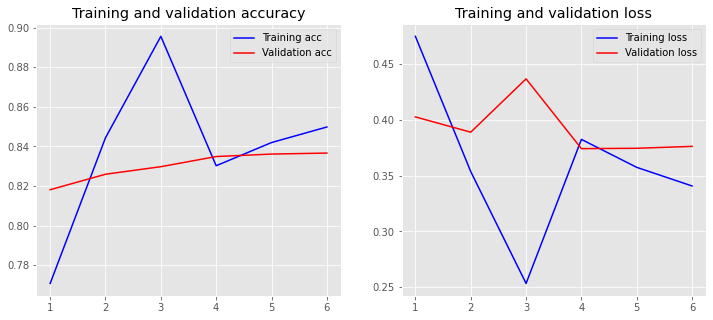

In [ ]:
plot_history(history)

Our lines aren't consistent as we changed the training dataset. However, you can see that both the `val_accuracy` and `val_loss` improved. At his point we could itterate again and improve the model a bit more and more. Just understand that every incrimental improvement will take more data/time as it significantly slows down over time.

# Is BERT worth it?

So is BERT worth. BERT is a huge model compared to our simple NN and Logistic Regression models we used before. Is the increase in accuracy impactful enough compared to the increase in computation needed? Let's comapre accuracy:


1.   Logistic Regression 0.80
2.   Simple NN           0.79
3.   Finetuned BERT      0.84

In this case it totally depends on you. I personaly would say let's use Logistic Regression. Easily deployable, low computational resources and the task isn't that signicificant in terms of a mistake. If your goal is maximum accuracy possible I would train BERT a bit more and try to get to at least 85%, that would be significant enough to use BERT instead a much less computationaly intesnive Logistic Regression.



# Test

We need to check in with our label encoder to get our classes.

In [7]:
encoder_fname = 'twitter_classes.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

This is how our classes are encoded for the model.

In [8]:
encoder.classes_

array([0, 4])

And additional feature encoder.

In [9]:
encoder_fname = 'twitter_wkd.npy'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

featureEncoderSaved = LabelEncoder()
featureEncoderSaved.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

In [10]:
featureEncoderSaved.classes_

array(['Fri', 'Mon', 'Sat', 'Sun', 'Thu', 'Tue', 'Wed'], dtype=object)

Same with our tokenizer.

In [14]:
model_fname = 'twitter_BERT_wWKD'
my_wd = '/content/drive/My Drive/YouTube/botters_2020-10/twitter_sentiment_course/'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

Input preprocessing.

In [46]:
tweet = ["Amazing tweet!"]
wkd = ['Mon']

dummy_wkd = np_utils.to_categorical(featureEncoderSaved.transform(np.array(wkd)))  # encodes weekday

inputs = bert_encode(string_list=list(tweet),
                      tokenizer=tokenizerSaved,
                      new_feature=dummy_wkd,
                      new_feature_class_count=7,
                      max_seq_length=240)

Prediction.

In [47]:
prediction = new_model.predict(inputs)
print(prediction)
print('Tweet is', 'positive' if encoder.classes_[np.argmax(prediction)]==4 else 'negative')

[[1.9829383e-04 9.9980170e-01]]
Tweet is positive
